<a href="https://colab.research.google.com/github/NIHITHPENUMUCHU/Predicting-Psychological-Mental-Health-Disorders-Using-EEG-Signals/blob/main/Predicting%20Psychological%20Mental%20Health%20Disorder%20from%20EEG%20signals%20using%20Random%20Forest%2C%20Neural%20Network%20and%20Hybrid%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving EEG.machinelearing_data_BRMH.csv to EEG.machinelearing_data_BRMH (4).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB
None
   no. sex   age    eeg.date  education     IQ       main.disorder  \
0    1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1    2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2    3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3    4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4    5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   

      specific.disorder  AB.A.delta.a.FP1  AB.A.delta.b.FP2  ...  \
0  Alcohol use disorder         35.998557         21.717375  ...   
1  Alcohol use disorder         13.425118         11.002916  ...   
2  Alcohol use disorder         29.941780         27.544684  ...   
3  Alcohol use disorder         2

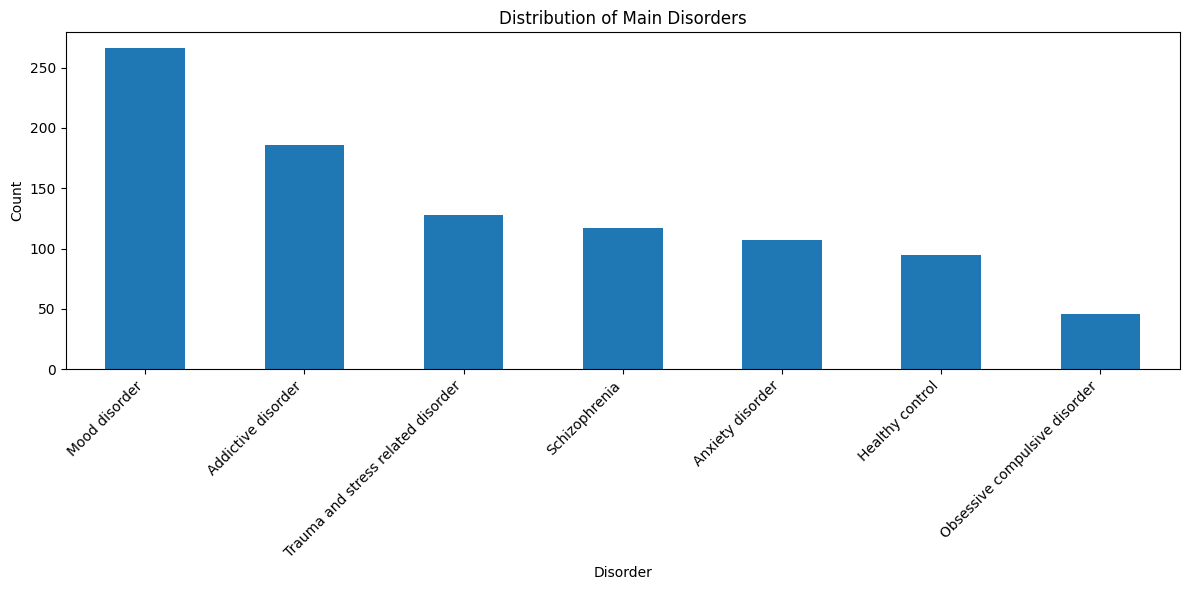

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))

print(df.info())

print(df.head())

print(df.isnull().sum())

print(df.describe())

plt.figure(figsize=(12, 6))
df['main.disorder'].value_counts().plot(kind='bar')
plt.title('Distribution of Main Disorders')
plt.xlabel('Disorder')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

df = pd.read_csv('EEG.machinelearing_data_BRMH.csv')

df = df.copy()

df.dropna(axis=1, how='all', inplace=True)

numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

numeric_imputer = SimpleImputer(strategy='mean')
df.loc[:, numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df.loc[:, categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

le_dict = {}
for col in categorical_columns:
    if col not in ['main.disorder', 'specific.disorder']:
        le = LabelEncoder()
        df.loc[:, col] = le.fit_transform(df[col])
        le_dict[col] = le

X = df.drop(['main.disorder', 'specific.disorder'], axis=1)
y_main = df['main.disorder']
y_binary = (df['main.disorder'] == 'Healthy control').astype(int)

le_main = LabelEncoder()
y_main_encoded = le_main.fit_transform(y_main)

X_train, X_test, y_main_train, y_main_test, y_binary_train, y_binary_test = train_test_split(
    X, y_main_encoded, y_binary, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

np.save('X_train_scaled.npy', X_train_scaled)
np.save('X_test_scaled.npy', X_test_scaled)
np.save('y_main_train.npy', y_main_train)
np.save('y_main_test.npy', y_main_test)
np.save('y_binary_train.npy', y_binary_train)
np.save('y_binary_test.npy', y_binary_test)

np.save('feature_names.npy', X.columns.values)

import joblib
joblib.dump(le_main, 'le_main.joblib')

print("Saved preprocessed data and label encoder.")

Data preprocessing completed.
Training set shape: (756, 1146)
Test set shape: (189, 1146)
Saved preprocessed data and label encoder.


Random Forest - Main Disorder Classification:
Accuracy: 0.4074
                                    precision    recall  f1-score   support

                Addictive disorder       0.43      0.68      0.53        34
                  Anxiety disorder       0.00      0.00      0.00        16
                   Healthy control       0.60      0.16      0.25        19
                     Mood disorder       0.41      0.89      0.56        56
     Obsessive compulsive disorder       1.00      0.11      0.20         9
                     Schizophrenia       0.00      0.00      0.00        20
Trauma and stress related disorder       0.00      0.00      0.00        35

                          accuracy                           0.41       189
                         macro avg       0.35      0.26      0.22       189
                      weighted avg       0.31      0.41      0.30       189


Random Forest - Binary Classification (Healthy vs. Unhealthy):
Accuracy: 0.9048
              pre

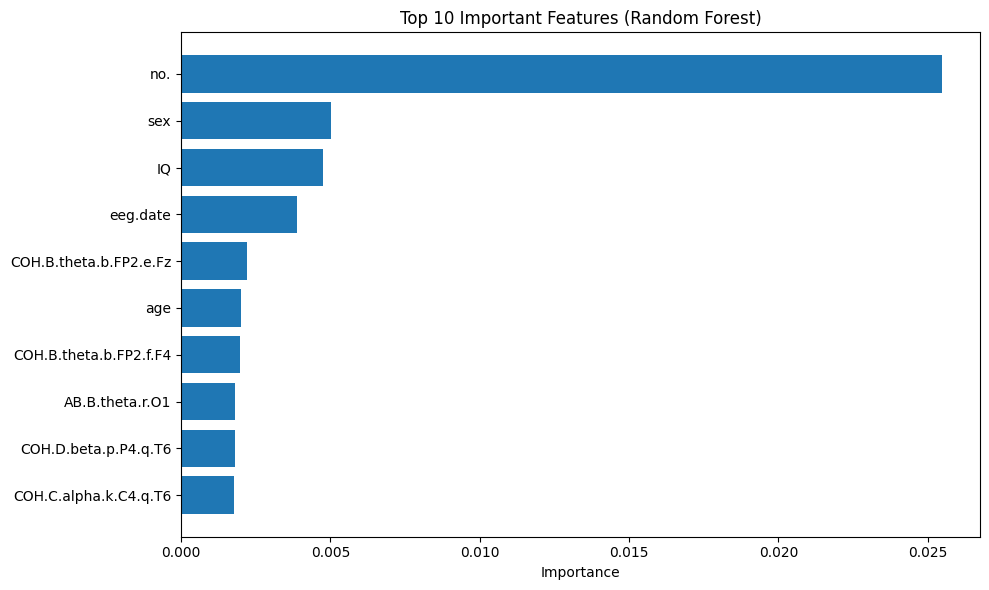

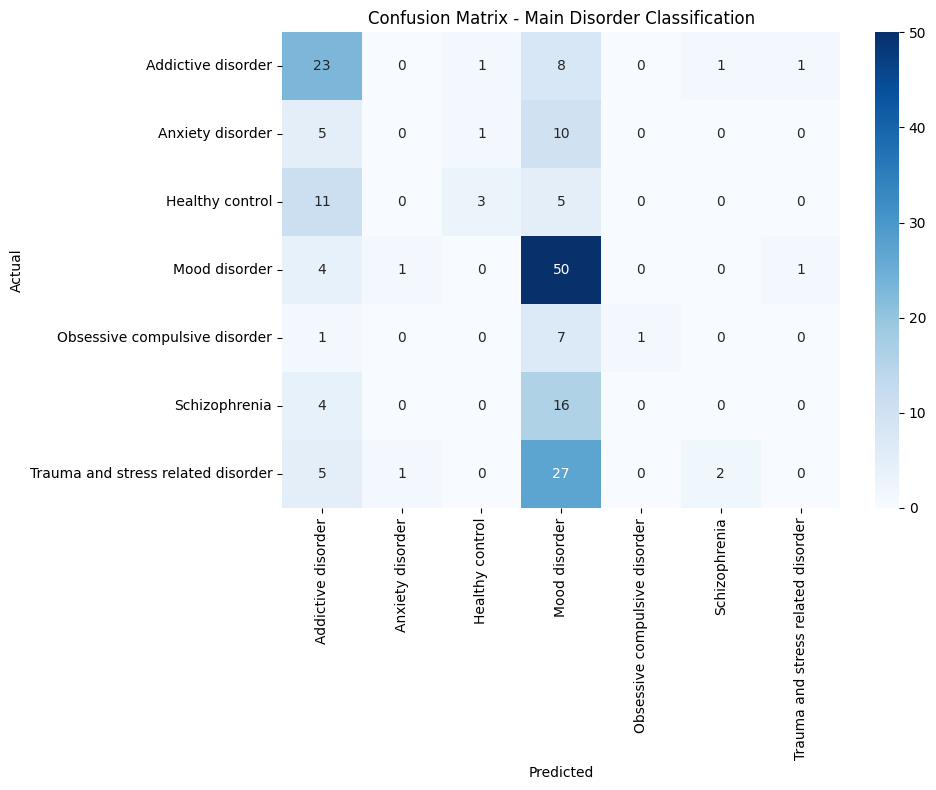

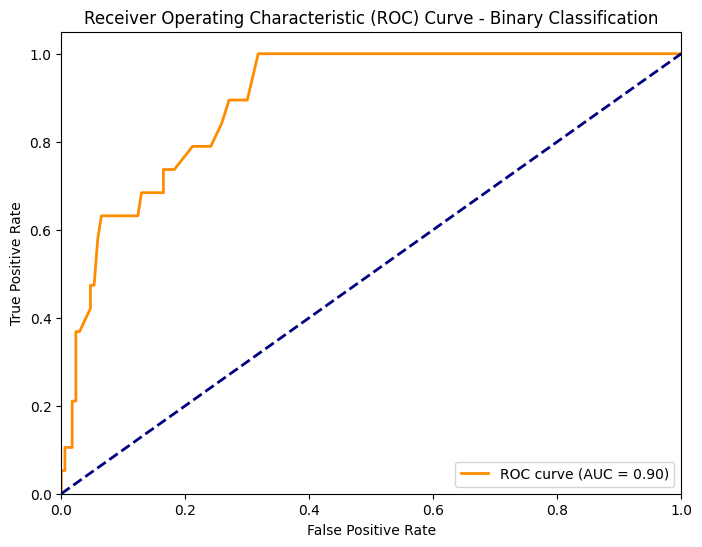

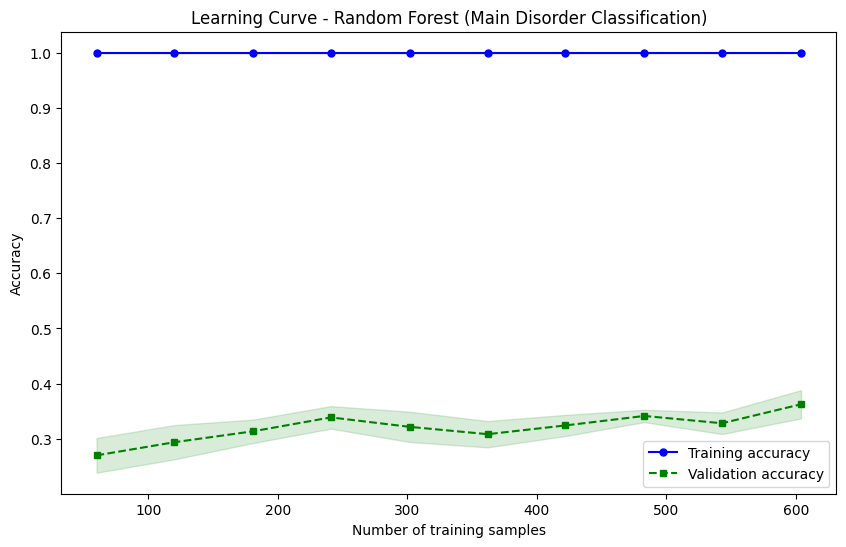


Analysis completed. Models and visualizations have been generated.


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

X_train_scaled = np.load('X_train_scaled.npy')
X_test_scaled = np.load('X_test_scaled.npy')
y_main_train = np.load('y_main_train.npy')
y_main_test = np.load('y_main_test.npy')
y_binary_train = np.load('y_binary_train.npy')
y_binary_test = np.load('y_binary_test.npy')

le_main = joblib.load('le_main.joblib')

try:
    feature_names = np.load('feature_names.npy', allow_pickle=True)
except FileNotFoundError:
    print("Feature names file not found. Using generic feature names.")
    feature_names = [f"feature_{i}" for i in range(X_train_scaled.shape[1])]

rf_main = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42)

rf_main.fit(X_train_scaled, y_main_train)
rf_binary.fit(X_train_scaled, y_binary_train)

y_main_pred_rf = rf_main.predict(X_test_scaled)
y_binary_pred_rf = rf_binary.predict(X_test_scaled)

print("Random Forest - Main Disorder Classification:")
print(f"Accuracy: {accuracy_score(y_main_test, y_main_pred_rf):.4f}")
print(classification_report(y_main_test, y_main_pred_rf, target_names=le_main.classes_))

print("\nRandom Forest - Binary Classification (Healthy vs. Unhealthy):")
print(f"Accuracy: {accuracy_score(y_binary_test, y_binary_pred_rf):.4f}")
print(classification_report(y_binary_test, y_binary_pred_rf))

feature_importance = rf_main.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_10_features = feature_names[sorted_idx][-10:]
top_10_importance = feature_importance[sorted_idx][-10:]

plt.figure(figsize=(10, 6))
plt.barh(top_10_features, top_10_importance)
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

joblib.dump(rf_main, 'rf_main_model.joblib')
joblib.dump(rf_binary, 'rf_binary_model.joblib')

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_main_test, y_main_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_main.classes_, yticklabels=le_main.classes_)
plt.title('Confusion Matrix - Main Disorder Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_binary_test, rf_binary.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Binary Classification')
plt.legend(loc="lower right")
plt.show()

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_scaled, y_main_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Random Forest (Main Disorder Classification)')
plt.legend(loc='lower right')
plt.show()

print("\nAnalysis completed. Models and visualizations have been generated.")

Epoch [10/100], Loss: 1.1745
Epoch [20/100], Loss: 0.6268
Epoch [30/100], Loss: 0.4881
Epoch [40/100], Loss: 0.3163
Epoch [50/100], Loss: 0.2775
Epoch [60/100], Loss: 0.1269
Epoch [70/100], Loss: 0.0840
Epoch [80/100], Loss: 0.0679
Early stopping at epoch 89
Neural Network - Main Disorder Classification:
Accuracy: 0.3122
                                    precision    recall  f1-score   support

                Addictive disorder       0.35      0.41      0.38        34
                  Anxiety disorder       0.05      0.06      0.06        16
                   Healthy control       0.50      0.47      0.49        19
                     Mood disorder       0.38      0.38      0.38        56
     Obsessive compulsive disorder       0.33      0.33      0.33         9
                     Schizophrenia       0.21      0.20      0.21        20
Trauma and stress related disorder       0.26      0.20      0.23        35

                          accuracy                           0.31  

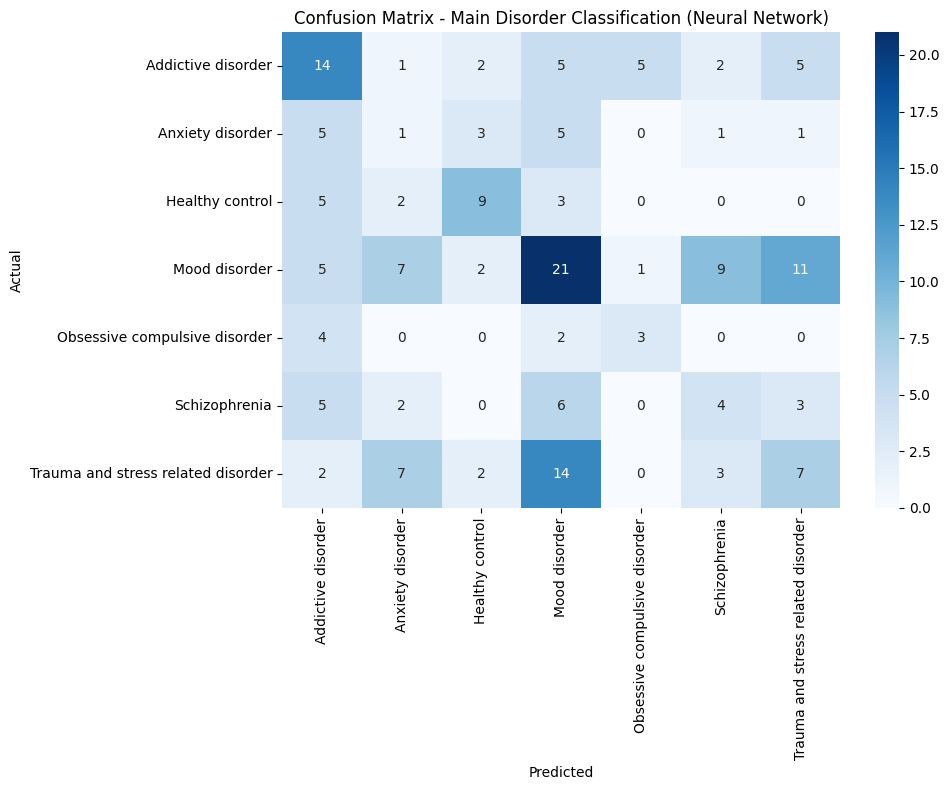

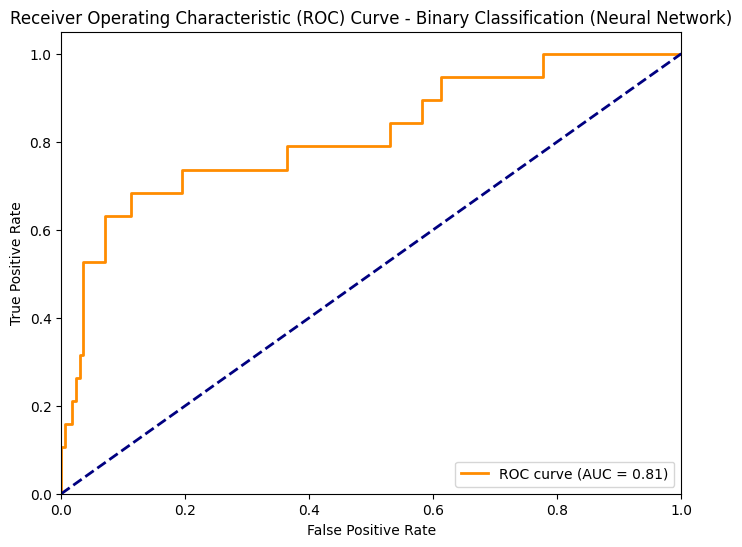


Analysis completed. Models and visualizations have been generated.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

X_train_scaled = np.load('X_train_scaled.npy')
X_test_scaled = np.load('X_test_scaled.npy')
y_main_train = np.load('y_main_train.npy')
y_main_test = np.load('y_main_test.npy')
y_binary_train = np.load('y_binary_train.npy')
y_binary_test = np.load('y_binary_test.npy')

le_main = joblib.load('le_main.joblib')

class_weights_main = compute_class_weight(class_weight='balanced', classes=np.unique(y_main_train), y=y_main_train)
class_weights_main = torch.FloatTensor(class_weights_main)

class_weights_binary = compute_class_weight(class_weight='balanced', classes=np.unique(y_binary_train), y=y_binary_train)
class_weights_binary = torch.FloatTensor(class_weights_binary)

class ImprovedNeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_main_train_tensor = torch.LongTensor(y_main_train)
y_main_test_tensor = torch.LongTensor(y_main_test)
y_binary_train_tensor = torch.LongTensor(y_binary_train)
y_binary_test_tensor = torch.LongTensor(y_binary_test)

train_dataset_main = TensorDataset(X_train_tensor, y_main_train_tensor)
test_dataset_main = TensorDataset(X_test_tensor, y_main_test_tensor)
train_loader_main = DataLoader(train_dataset_main, batch_size=32, shuffle=True)
test_loader_main = DataLoader(test_dataset_main, batch_size=32, shuffle=False)

input_size = X_train_scaled.shape[1]
num_classes_main = len(np.unique(y_main_train))
num_classes_binary = 2

nn_main = ImprovedNeuralNetwork(input_size, num_classes_main)
nn_binary = ImprovedNeuralNetwork(input_size, num_classes_binary)

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        scheduler.step(epoch_loss)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

criterion_main = nn.CrossEntropyLoss(weight=class_weights_main)
optimizer_main = optim.Adam(nn_main.parameters(), lr=0.001)
scheduler_main = optim.lr_scheduler.ReduceLROnPlateau(optimizer_main, mode='min', factor=0.1, patience=5)
train_model(nn_main, train_loader_main, criterion_main, optimizer_main, scheduler_main)

nn_main.eval()
with torch.no_grad():
    y_main_pred_nn = nn_main(X_test_tensor).argmax(dim=1).numpy()

print("Neural Network - Main Disorder Classification:")
print(f"Accuracy: {accuracy_score(y_main_test, y_main_pred_nn):.4f}")
print(classification_report(y_main_test, y_main_pred_nn, target_names=le_main.classes_))

train_dataset_binary = TensorDataset(X_train_tensor, y_binary_train_tensor)
train_loader_binary = DataLoader(train_dataset_binary, batch_size=32, shuffle=True)

criterion_binary = nn.CrossEntropyLoss(weight=class_weights_binary)
optimizer_binary = optim.Adam(nn_binary.parameters(), lr=0.001)
scheduler_binary = optim.lr_scheduler.ReduceLROnPlateau(optimizer_binary, mode='min', factor=0.1, patience=5)
train_model(nn_binary, train_loader_binary, criterion_binary, optimizer_binary, scheduler_binary)

nn_binary.eval()
with torch.no_grad():
    y_binary_pred_nn = nn_binary(X_test_tensor).argmax(dim=1).numpy()

print("\nNeural Network - Binary Classification (Healthy vs. Unhealthy):")
print(f"Accuracy: {accuracy_score(y_binary_test, y_binary_pred_nn):.4f}")
print(classification_report(y_binary_test, y_binary_pred_nn))

torch.save(nn_main.state_dict(), 'nn_main_model.pth')
torch.save(nn_binary.state_dict(), 'nn_binary_model.pth')

cm = confusion_matrix(y_main_test, y_main_pred_nn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_main.classes_, yticklabels=le_main.classes_)
plt.title('Confusion Matrix - Main Disorder Classification (Neural Network)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve, auc

y_binary_pred_proba = nn_binary(X_test_tensor).softmax(dim=1)[:, 1].detach().numpy()
fpr, tpr, _ = roc_curve(y_binary_test, y_binary_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Binary Classification (Neural Network)')
plt.legend(loc="lower right")
plt.show()

print("\nAnalysis completed. Models and visualizations have been generated.")

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        weights = self.attention(x)
        return torch.mul(x, weights)

class ImprovedNeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedNeuralNetwork, self).__init__()

        self.attention = AttentionLayer(input_size)

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.attention(x)
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output, features

class ImprovedHybridModel:
    def __init__(self, input_size, num_classes, n_folds=5, is_binary=False):
        self.input_size = input_size
        self.num_classes = num_classes
        self.n_folds = n_folds
        self.is_binary = is_binary

        self.rf_models = []
        self.nn_models = []

        if is_binary:
            self.meta_learner = xgb.XGBClassifier(
                learning_rate=0.01,
                n_estimators=300,
                max_depth=3,
                min_child_weight=1,
                gamma=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='binary:logistic',
                scale_pos_weight=5,
                seed=42
            )
        else:
            self.meta_learner = xgb.XGBClassifier(
                learning_rate=0.01,
                n_estimators=200,
                max_depth=4,
                min_child_weight=2,
                gamma=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='multi:softprob',
                num_class=num_classes,
                seed=42
            )

    def train_fold(self, X_train, y_train, X_val, y_val):
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight=class_weight_dict,
            random_state=42
        )
        rf.fit(X_train, y_train)

        nn_model = ImprovedNeuralNetwork(self.input_size, self.num_classes)
        criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
        optimizer = optim.AdamW(nn_model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

        train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        best_val_acc = 0
        patience = 10
        patience_counter = 0

        for epoch in range(100):
            nn_model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs, _ = nn_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            nn_model.eval()
            with torch.no_grad():
                val_outputs, _ = nn_model(torch.FloatTensor(X_val))
                val_preds = torch.argmax(val_outputs, dim=1).numpy()
                val_acc = accuracy_score(y_val, val_preds)

                scheduler.step(val_acc)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    break

        return rf, nn_model

    def get_meta_features(self, X, rf_model, nn_model):
        rf_proba = rf_model.predict_proba(X)

        nn_model.eval()
        with torch.no_grad():
            outputs, features = nn_model(torch.FloatTensor(X))
            nn_proba = torch.softmax(outputs, dim=1).numpy()
            nn_features = features.numpy()

        meta_features = np.hstack([rf_proba, nn_proba, nn_features])
        return meta_features

    def fit(self, X, y):
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        meta_features = np.zeros((X.shape[0], self.num_classes * 2 + 128))

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            rf_model, nn_model = self.train_fold(X_train, y_train, X_val, y_val)
            self.rf_models.append(rf_model)
            self.nn_models.append(nn_model)

            meta_features[val_idx] = self.get_meta_features(X_val, rf_model, nn_model)

        self.meta_learner.fit(meta_features, y)
        return self

    def predict(self, X):
        meta_features = np.zeros((X.shape[0], self.num_classes * 2 + 128))

        for rf_model, nn_model in zip(self.rf_models, self.nn_models):
            fold_meta_features = self.get_meta_features(X, rf_model, nn_model)
            meta_features += fold_meta_features

        meta_features /= self.n_folds
        return self.meta_learner.predict(meta_features)

def train_improved_hybrid_model(X_train_scaled, y_train, X_test_scaled, y_test, le_main=None, is_binary=False):
    num_classes = 2 if is_binary else len(np.unique(y_train))

    hybrid_model = ImprovedHybridModel(
        input_size=X_train_scaled.shape[1],
        num_classes=num_classes,
        is_binary=is_binary
    )

    hybrid_model.fit(X_train_scaled, y_train)
    y_pred = hybrid_model.predict(X_test_scaled)

    print(f"\nImproved Hybrid {'Binary' if is_binary else 'Main'} Classification Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    if is_binary:
        print(classification_report(y_test, y_pred, target_names=['Unhealthy', 'Healthy'], zero_division=0))
    else:
        print(classification_report(y_test, y_pred, target_names=le_main.classes_, zero_division=0))

    return hybrid_model

le_binary = LabelEncoder()
y_binary_train_encoded = le_binary.fit_transform(y_binary_train)
y_binary_test_encoded = le_binary.transform(y_binary_test)

hybrid_main = train_improved_hybrid_model(
    X_train_scaled, y_main_train, X_test_scaled, y_main_test, le_main, False
)

hybrid_binary = train_improved_hybrid_model(
    X_train_scaled, y_binary_train_encoded, X_test_scaled, y_binary_test_encoded, None, True
)


Improved Hybrid Main Classification Results:
Accuracy: 0.4233
                                    precision    recall  f1-score   support

                Addictive disorder       0.58      0.62      0.60        34
                  Anxiety disorder       0.00      0.00      0.00        16
                   Healthy control       0.43      0.47      0.45        19
                     Mood disorder       0.38      0.89      0.53        56
     Obsessive compulsive disorder       0.00      0.00      0.00         9
                     Schizophrenia       0.00      0.00      0.00        20
Trauma and stress related disorder       0.00      0.00      0.00        35

                          accuracy                           0.42       189
                         macro avg       0.20      0.28      0.23       189
                      weighted avg       0.26      0.42      0.31       189


Improved Hybrid Binary Classification Results:
Accuracy: 0.9101
              precision    recall